In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
## This notebook tests the hypothesis presented in this document:
##  https://www.overleaf.com/project/6646149ffbda4a6cc359244d

In [17]:
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

In [18]:
class Buyer:
    def __init__(self, id):
        self.id = 'Buyer_' + str(id)

class Seller:
    def __init__(self, id):
        self.id = 'Seller_' + str(id)
        self.fees_vec = []
        self.total_fees_vec = []
        self.weight_vec = []
        self.total_weight_vec = []

    def step(self, fees = 0, weight = 0):
        self.update_fees_paid(fees)
        self.update_weight(weight)

    def update_fees_paid(self, fees):
        self.fees_vec.append(fees)
        if len(self.total_fees_vec) == 0:
            self.total_fees_vec.append(fees)
        else:
            total_fees_paid = self.total_fees_vec[-1] + fees
            self.total_fees_vec.append(total_fees_paid)

    def update_weight(self, weight):
        self.weight_vec.append(weight)
        if len(self.total_weight_vec) == 0:
            self.total_weight_vec.append(weight)
        else:
            total_weight = self.total_weight_vec[-1] + weight
            self.total_weight_vec.append(total_weight)

    def __str__(self):
        return f"ID: {self.id}, Fees Paid: {self.fees_paid}, Total Weight: {self.total_weight}"

class DynamicSimulation:
    def __init__(self, 
                 n_buyers=10, 
                 seller_u_connectivity_fraction=0.8, 
                 seller_s_connectivity_fraction=0.2,
                 seed=123):
        self.rng = np.random.default_rng(seed)
        # create a blank graph representation of the network
        self.graph = nx.Graph()

        self.seller_u_connectivity_fraction = seller_u_connectivity_fraction
        self.seller_s_connectivity_fraction = seller_s_connectivity_fraction

        # create N buyers
        self.n_buyers = n_buyers
        self.buyers = [Buyer(i) for i in range(n_buyers)]

        # create u and s producers.  u is highly connected, s is sparsely connected
        self.sellers = [Seller(i) for i in range(2)]
        
        # make seller 1 the highly connected seller (connected to 80% of buyers)
        buyer_idxs_connect = self.rng.choice(n_buyers, int(seller_u_connectivity_fraction * n_buyers), replace=False)
        for ix in buyer_idxs_connect:
            w = self.rng.uniform(0, 1)
            self.graph.add_edge(self.sellers[0], self.buyers[ix], weight=w)

        # make seller 2 the lowly connected seller (connected to 20% of buyers)
        buyer_idxs_connect = self.rng.choice(n_buyers, int(seller_s_connectivity_fraction * n_buyers), replace=False)
        for ix in buyer_idxs_connect:
            w = self.rng.uniform(0, 1)
            self.graph.add_edge(self.sellers[1], self.buyers[ix], weight=w)

    def transaction_value_to_weight_and_fees(self, transaction_value):
        # TODO: define this in more detail
        graph_weight_for_transaction = 0.9 * transaction_value
        fees_for_transaction = 0.1 * transaction_value
        return graph_weight_for_transaction, fees_for_transaction

    def step(self, transact_probability=0.5):
        # determine whether we will transact
        will_transact = self.rng.uniform(0, 1) < transact_probability
        if not will_transact:
            for seller in self.sellers:
                seller.step(fees=0, weight=0)
            return

        buyer = self.rng.choice(self.buyers)
        transaction_value = self.rng.uniform(0, 1)
        graph_weight_for_transaction, fees_for_transaction = self.transaction_value_to_weight_and_fees(transaction_value)

        # TODO: which seller is this buyer transacting with?
        seller_to_transact_with = self.rng.uniform(0, 1) < self.seller_u_connectivity_fraction
        if seller_to_transact_with == 0:
            # tranasct w/ highly connected seller
            seller = self.sellers[0]
            other_seller = self.sellers[1]
        else:
            # tranasct w/ sparsely connected seller
            seller = self.sellers[1]
            other_seller = self.sellers[0]

        # update graph with the new transaction
        if self.graph.has_edge(buyer, seller):
            # TODO: what is the update rule for the graph weight?
            self.graph[buyer][seller]['weight'] += graph_weight_for_transaction
        else:
            self.graph.add_edge(buyer, seller, weight=graph_weight_for_transaction)
        
        # get the total weight of the seller, and set the attribute for easy access
        new_total_weight = sum([self.graph[seller][buyer]['weight'] for buyer in self.buyers if self.graph.has_edge(seller, buyer)])

        # step the agents for plotting
        seller.step(fees=fees_for_transaction, weight=new_total_weight)
        other_seller.step(fees=0, weight=0)
        

    def run(self, transact_probability_vector):
        for ii in range(len(transact_probability_vector)):
            transact_probability = transact_probability_vector[ii]
            self.step(transact_probability=transact_probability)

In [19]:
n_buyers = 20
seller_u_connectivity_fraction = 0.8
seller_s_connectivity_fraction = 0.2
ds = DynamicSimulation(
    n_buyers=n_buyers, 
    seller_u_connectivity_fraction=seller_u_connectivity_fraction, 
    seller_s_connectivity_fraction=seller_s_connectivity_fraction,
    seed=123
)
transact_probability_vector = np.ones(100)*0.5
ds.run(transact_probability_vector=transact_probability_vector)

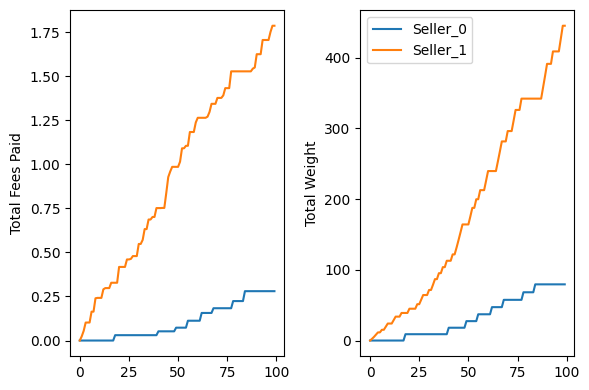

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
for seller in ds.sellers:
    ax[0].plot(seller.total_fees_vec, label=seller.id)
    ax[1].plot(seller.total_weight_vec, label=seller.id)
ax[1].legend()
ax[0].set_ylabel('Total Fees Paid')
ax[1].set_ylabel('Total Weight')
plt.tight_layout()